# Parameters used
  * Query profile size: 10
  * Number of query profiles: 5
  * Information Content: Annotation IC
  * Profile aggregation: Best Pairs
  * Directionality of similarity: Symmetric

### 1. Import required modules

In [17]:
import matplotlib.lines as mlines
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
%matplotlib inline

### 2. Helper methods

In [18]:
def load_results(infile,quartile,scores,metric,granularity):
    next(infile)
    for line in infile:
        queryid,numreplaced,match,score=line.strip().split()
        numreplaced=int(numreplaced)
        if metric not in scores:
            scores[metric]=dict()
        if quartile not in scores[metric]:
            scores[metric][quartile]=dict()
        if granularity not in scores[metric][quartile]:
            scores[metric][quartile][granularity]=dict()
        if numreplaced not in scores[metric][quartile][granularity]:
            scores[metric][quartile][granularity][numreplaced]=[]
        scores[metric][quartile][granularity][numreplaced].append(float(score))

    infile.close()
    return scores

def error(scorelist):
    return 2*(np.std(scorelist)/math.sqrt(len(scorelist)))

### 2. Plot decay and noise

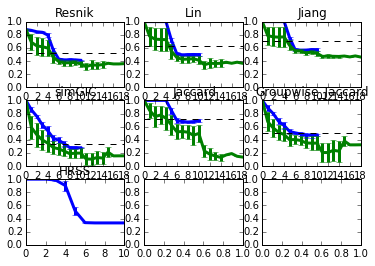

In [23]:
    scores=dict()
    quartile=50
    granularity='E'
    f, axarr = plt.subplots(3, 3)
    i=j=0
    titledict={'BPSym__Jaccard':'Jaccard','BPSym_AIC_Resnik':'Resnik','BPSym_AIC_Lin':'Lin'
               ,'BPSym_AIC_Jiang':'Jiang','_AIC_simGIC':'simGIC','BPAsym_AIC_HRSS':'HRSS','Groupwise_Jaccard':'Groupwise_Jaccard'}
    lines=[]
    legend=[]
    for profilesize in [10]:
        for metric in ['BPSym_AIC_Resnik','BPSym_AIC_Lin','BPSym_AIC_Jiang','_AIC_simGIC','BPSym__Jaccard',
                       'Groupwise_Jaccard','BPAsym_AIC_HRSS']:
            
            # plotting annotation replacement
            infile=open("../../results/FullDistribution/AnnotationReplacement/E_Decay_Quartile50_ProfileSize"+str(profilesize)+"_"+ metric+"_Results.tsv")
            scores=load_results(infile,quartile,scores,metric,granularity)
            infile.close()
            signallist=[]
            errorlist=[]
            numreplacedlist=sorted(scores[metric][quartile][granularity].keys())
           
            for numreplaced in numreplacedlist :
                signallist.append(np.mean(scores[metric][quartile][granularity][numreplaced]))
                errorlist.append(error(scores[metric][quartile][granularity][numreplaced]))
            line=axarr[i][j].errorbar(numreplacedlist,signallist,yerr=errorlist,color='blue',linewidth=3)
            if len(lines)==0:
                lines.append(line)
                legend.append("Annotation Replacement")
            axarr[i][j].set_title(titledict[metric])
            axarr[i][j].set_ylim(0,1)


            # plotting Ancestral Replacement
            ancestralreplacementfile="../../results/FullDistribution/AncestralReplacement/E_Decay_Quartile50_ProfileSize"+str(profilesize)+"_"+ metric+"_Results.tsv"
            
            if os.path.isfile(ancestralreplacementfile):
                infile=open(ancestralreplacementfile)
                scores=load_results(infile,quartile,scores,metric,granularity)
                infile.close()
                signallist=[]
                errorlist=[]
                numreplacedlist=sorted(scores[metric][quartile][granularity].keys())
                for numreplaced in numreplacedlist :
                    signallist.append(np.mean(scores[metric][quartile][granularity][numreplaced]))
                    errorlist.append(error(scores[metric][quartile][granularity][numreplaced]))
                line=axarr[i][j].errorbar(numreplacedlist,signallist,yerr=errorlist,color='green',linewidth=3)
                if len(lines)==1:
                    lines.append(line)
                    legend.append("Ancestral Replacement")
                
            # plotting noise
            decaytype="AnnotationReplacement"
            if "simGIC" in metric or "Groupwise_Jaccard" in metric:
                noisefile="../../results/FullDistribution/"+decaytype+"/Noise/Distributions/"+granularity+"_Noise_Quartile"+str(quartile)+"_ProfileSize"+str(profilesize)+"_"+metric+"_Results.tsv"
            else:
                noisefile="../../results/FullDistribution/"+decaytype+"/Noise/Distributions/"+granularity+"_NoiseDecay_Quartile"+str(quartile)+"_ProfileSize"+str(profilesize)+"_"+metric+"_Results.tsv"
            if os.path.isfile(noisefile):
                noisedist= json.load(open(noisefile))
                line=axarr[i][j].axhline(y=np.percentile(noisedist,99.9),linestyle='--',color='black',label='_nolegend_')
                if len(lines)==2:
                    lines.append(line)
                    legend.append("99.9 percentile noise")
            if j==2:
                j=0
                i+=1
            else:
                j+=1